In [2]:
!pip install pennylane

# ------------------------
# Imports
# ------------------------
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
from collections import defaultdict
from PIL import Image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.2 MB/s eta 0:00:00:00:0100:01


In [3]:
# ------------------------
# Helper Functions
# ------------------------
def is_anomaly(path):
    return 0 if "good" in path else 1

# ------------------------
# Dataset Class
# ------------------------
class CustomMVTecDataset(Dataset):
    def __init__(self, root_dir, transform, class_to_idx, phase="train"):
        self.samples = []
        self.class_to_idx = class_to_idx
        self.phase = phase
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            phase_path = os.path.join(class_path, self.phase)
            if not os.path.exists(phase_path):
                continue
            for root, _, files in os.walk(phase_path):
                for f in files:
                    if f.endswith(".png"):
                        path = os.path.join(root, f)
                        label = is_anomaly(path)
                        class_id = self.class_to_idx[class_name]
                        self.samples.append((path, label, class_id))
        self.transform = transform

    def __getitem__(self, index):
        path, label, class_id = self.samples[index]
        image = default_loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label, class_id

    def __len__(self):
        return len(self.samples)


In [4]:
# ------------------------
# Transforms
# ------------------------
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ------------------------
# Dataset and DataLoader
# ------------------------
base_path = "/kaggle/input/mvtec-ad"
classes = sorted([cls for cls in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, cls))])
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

train_data = CustomMVTecDataset(base_path, transform, class_to_idx, phase="train")
test_data = CustomMVTecDataset(base_path, transform, class_to_idx, phase="test")
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [5]:
# ------------------------
# Encoder
# ------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128 * 16 * 16, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ------------------------
# Quantum Circuit
# ------------------------
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ------------------------
# Generator with Class Embedding
# ------------------------
class HybridGenerator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.class_embedding = nn.Embedding(num_classes, 4)
        self.pre_fc = nn.Sequential(
            nn.Linear(8, 128), nn.ReLU(),
            nn.Linear(128, n_qubits)
        )
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, {"weights": (3, n_qubits, 3)})
        self.post_fc = nn.Sequential(
            nn.Linear(n_qubits, 512), nn.ReLU(),
            nn.Linear(512, 64 * 64), nn.Tanh()
        )

    def forward(self, x, class_id):
        class_embed = self.class_embedding(class_id)
        x = torch.cat([x, class_embed], dim=1)
        x = self.pre_fc(x)
        x = self.q_layer(x)
        x = self.post_fc(x)
        return x.view(-1, 1, 64, 64)


In [6]:
encoder = Encoder()
generator = HybridGenerator(num_classes=len(classes))

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

encoder.apply(weights_init)
generator.apply(weights_init)

e_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)


Epoch [1/25] Recon Loss: 0.2085
Epoch [2/25] Recon Loss: 0.1095
Epoch [3/25] Recon Loss: 0.0986
Epoch [4/25] Recon Loss: 0.0925
Epoch [5/25] Recon Loss: 0.0758
Epoch [6/25] Recon Loss: 0.0580
Epoch [7/25] Recon Loss: 0.0494
Epoch [8/25] Recon Loss: 0.0440
Epoch [9/25] Recon Loss: 0.0402
Epoch [10/25] Recon Loss: 0.0376
Epoch [11/25] Recon Loss: 0.0360
Epoch [12/25] Recon Loss: 0.0347
Epoch [13/25] Recon Loss: 0.0337
Epoch [14/25] Recon Loss: 0.0329
Epoch [15/25] Recon Loss: 0.0323
Epoch [16/25] Recon Loss: 0.0317
Epoch [17/25] Recon Loss: 0.0310
Epoch [18/25] Recon Loss: 0.0305
Epoch [19/25] Recon Loss: 0.0299
Epoch [20/25] Recon Loss: 0.0293
Epoch [21/25] Recon Loss: 0.0288
Epoch [22/25] Recon Loss: 0.0283
Epoch [23/25] Recon Loss: 0.0278
Epoch [24/25] Recon Loss: 0.0274
Epoch [25/25] Recon Loss: 0.0270


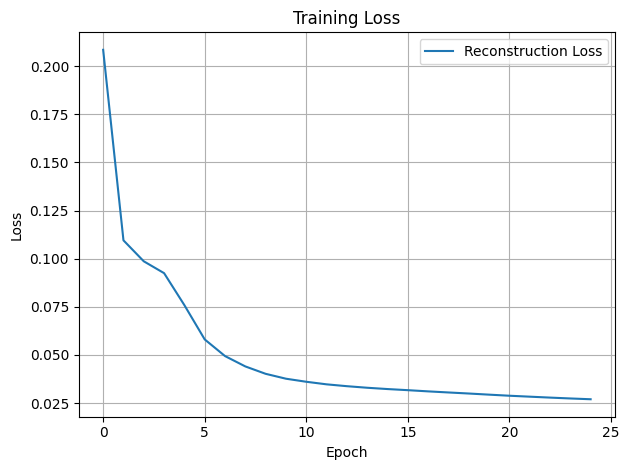

In [7]:
# ------------------------
# Training Loop
# ------------------------
epochs = 25
recon_losses = []

for epoch in range(epochs):
    encoder.train()
    generator.train()
    epoch_loss = 0.0
    for real_imgs, _, class_ids in train_loader:
        z = encoder(real_imgs)
        recon_imgs = generator(z, class_ids)
        loss = F.mse_loss(recon_imgs, real_imgs)

        e_optimizer.zero_grad()
        g_optimizer.zero_grad()
        loss.backward()
        e_optimizer.step()
        g_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    recon_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Recon Loss: {avg_loss:.4f}")

torch.save(encoder.state_dict(), "encoder.pth")
torch.save(generator.state_dict(), "generator.pth")

plt.plot(recon_losses, label="Reconstruction Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# ------------------------
# Threshold Calculation (Per Class)
# ------------------------
thresholds = {}
generator.eval()
encoder.eval()
class_scores = {i: [] for i in range(len(classes))}

with torch.no_grad():
    for imgs, _, class_ids in train_loader:
        z = encoder(imgs)
        recons = generator(z, class_ids)
        batch_scores = torch.mean((imgs - recons) ** 2, dim=[1, 2, 3])
        for score, cid in zip(batch_scores, class_ids):
            class_scores[cid.item()].append(score.item())

for cid in range(len(classes)):
    if class_scores[cid]:  # Check if there are any scores
        thresholds[cid] = np.percentile(class_scores[cid], 90)  # 90th percentile as threshold
        print(f"[INFO] Class '{classes[cid]}' Threshold: {thresholds[cid]:.4f}")
    else:
        thresholds[cid] = None
        print(f"[WARNING] No training samples found for class '{classes[cid]}'.")


[INFO] Class 'bottle' Threshold: 0.0089
[INFO] Class 'cable' Threshold: 0.0937
[INFO] Class 'capsule' Threshold: 0.0053
[INFO] Class 'carpet' Threshold: 0.0109
[INFO] Class 'grid' Threshold: 0.1030
[INFO] Class 'hazelnut' Threshold: 0.0111
[INFO] Class 'leather' Threshold: 0.0057
[INFO] Class 'metal_nut' Threshold: 0.0643
[INFO] Class 'pill' Threshold: 0.0065
[INFO] Class 'screw' Threshold: 0.0502
[INFO] Class 'tile' Threshold: 0.0453
[INFO] Class 'toothbrush' Threshold: 0.0820
[INFO] Class 'transistor' Threshold: 0.0440
[INFO] Class 'wood' Threshold: 0.0149
[INFO] Class 'zipper' Threshold: 0.0203



Class: bottle
              precision    recall  f1-score   support

      Normal       0.49      0.90      0.63        20
     Anomaly       0.96      0.70      0.81        63

    accuracy                           0.75        83
   macro avg       0.72      0.80      0.72        83
weighted avg       0.84      0.75      0.76        83


Class: cable
              precision    recall  f1-score   support

      Normal       0.44      0.81      0.57        58
     Anomaly       0.74      0.34      0.46        92

    accuracy                           0.52       150
   macro avg       0.59      0.57      0.51       150
weighted avg       0.62      0.52      0.50       150


Class: capsule
              precision    recall  f1-score   support

      Normal       0.19      0.87      0.31        23
     Anomaly       0.88      0.20      0.33       109

    accuracy                           0.32       132
   macro avg       0.53      0.54      0.32       132
weighted avg       0.76      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


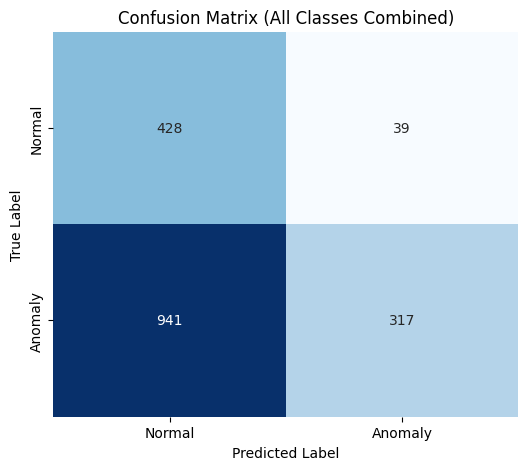

In [9]:
# ------------------------
# Evaluation
# ------------------------
true_labels, pred_labels, anomaly_scores, class_names_eval = [], [], [], []

generator.eval()
encoder.eval()

with torch.no_grad():
    for img, label, class_id in test_loader:
        z = encoder(img)
        recon = generator(z, class_id)
        score = torch.mean((img - recon) ** 2).item()

        threshold = thresholds.get(class_id.item(), None)
        if threshold is None:
            print(f"[WARNING] Skipping class ID {class_id.item()} - no threshold found.")
            continue

        pred = 1 if score > threshold else 0

        true_labels.append(label.item())
        pred_labels.append(pred)
        anomaly_scores.append(score)
        class_names_eval.append(classes[class_id.item()])

# ------------------------
# Metrics by Class
# ------------------------
per_class_true = defaultdict(list)
per_class_pred = defaultdict(list)

for t, p, name in zip(true_labels, pred_labels, class_names_eval):
    per_class_true[name].append(t)
    per_class_pred[name].append(p)

for name in classes:
    if len(per_class_true[name]) == 0:
        print(f"\n[WARNING] No test samples found for class '{name}'. Skipping report.")
        continue
    print(f"\nClass: {name}")
    print(classification_report(per_class_true[name], per_class_pred[name], target_names=["Normal", "Anomaly"]))

# ------------------------
# Confusion Matrix
# ------------------------
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Classes Combined)")
plt.xticks([0.5, 1.5], ['Normal', 'Anomaly'])
plt.yticks([0.5, 1.5], ['Normal', 'Anomaly'])
plt.show()


In [10]:
# ------------------------
# Generalized Single Image Prediction Function
# ------------------------
def predict_image(image_path, encoder, generator, thresholds, class_to_idx, transform, classes):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)

    # Detect class name from path
    class_name = [cls for cls in classes if cls in image_path]
    if not class_name:
        raise ValueError(f"[ERROR] Could not detect class from image path: {image_path}")
    class_id = torch.tensor([class_to_idx[class_name[0]]])

    encoder.eval()
    generator.eval()

    with torch.no_grad():
        z = encoder(image)
        recon = generator(z, class_id)
        score = torch.mean((image - recon) ** 2).item()

    threshold = thresholds.get(class_id.item(), None)
    if threshold is None:
        print(f"[WARNING] Threshold not available for class '{class_name[0]}'. Skipping.")
        return None, None

    prediction = 1 if score > threshold else 0

    print("\n===============================")
    print(f"Image Path    : {image_path}")
    print(f"Class         : {class_name[0]}")
    print(f"Anomaly Score : {score:.6f}")
    print(f"Threshold     : {threshold:.6f}")
    print(f"Prediction    : {'Anomaly 🚨' if prediction == 1 else 'Normal ✅'}")
    print("===============================\n")

    return score, prediction


In [11]:
# Example usage for any test image:
image_path = "/kaggle/input/mvtec-ad/bottle/test/broken_large/000.png"  # Change this path accordingly
predict_image(image_path, encoder, generator, thresholds, class_to_idx, transform, classes)



Image Path    : /kaggle/input/mvtec-ad/bottle/test/broken_large/000.png
Class         : bottle
Anomaly Score : 0.008914
Threshold     : 0.008898
Prediction    : Anomaly 🚨



(0.008913669735193253, 1)


[INFO] Generating ROC and PR curves for class: bottle


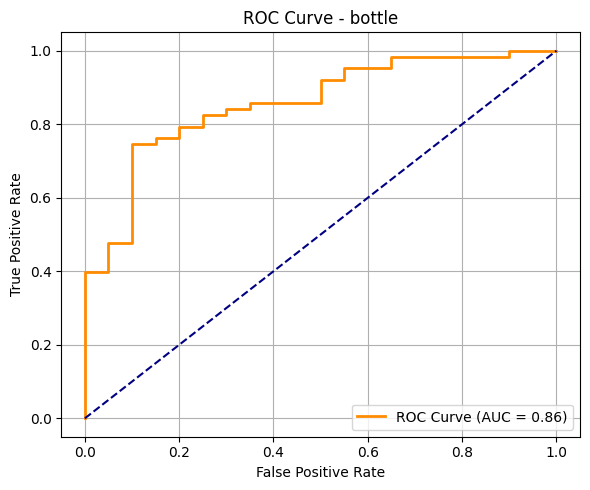

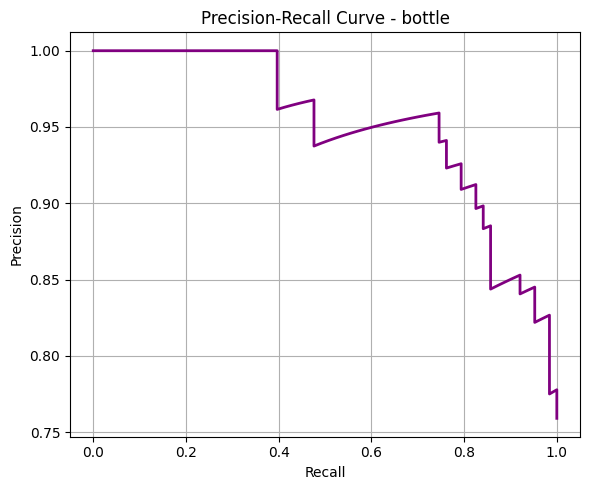

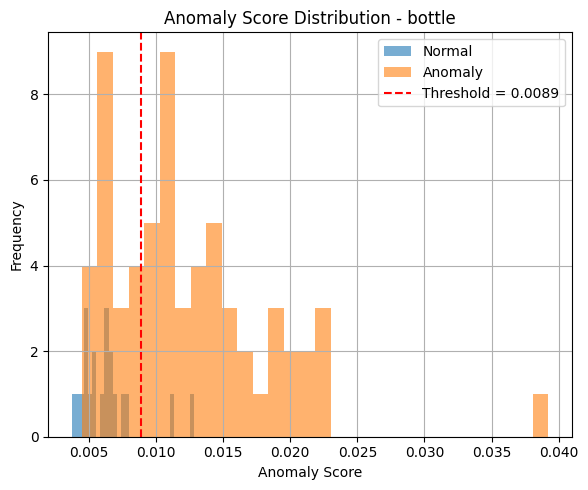


[INFO] Generating ROC and PR curves for class: cable


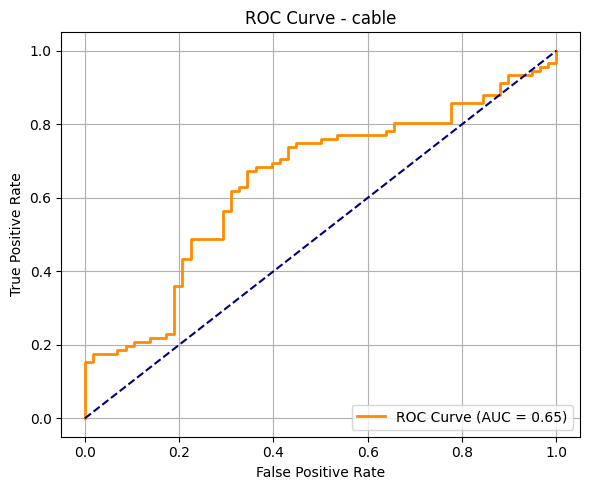

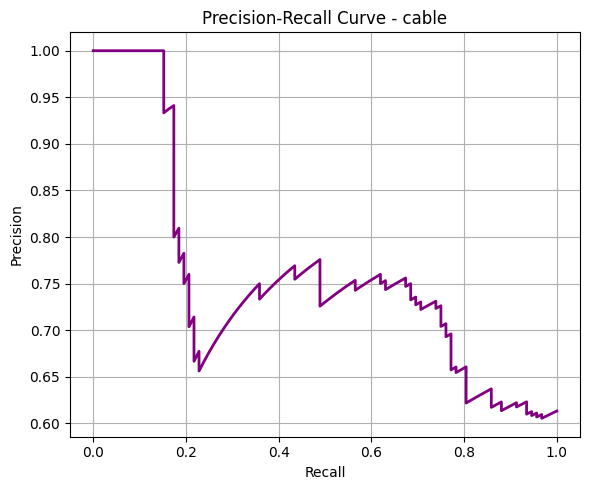

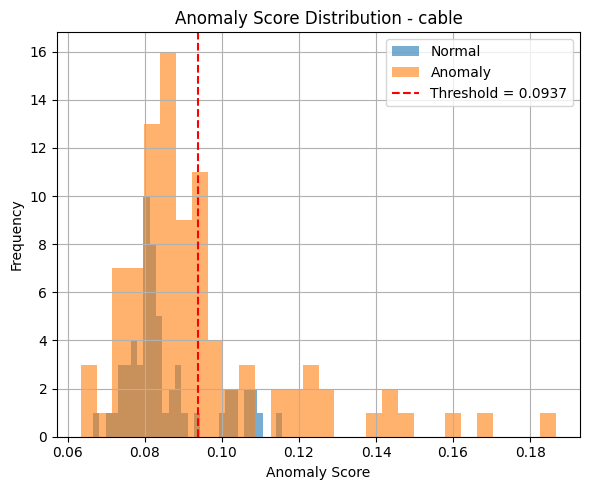


[INFO] Generating ROC and PR curves for class: capsule


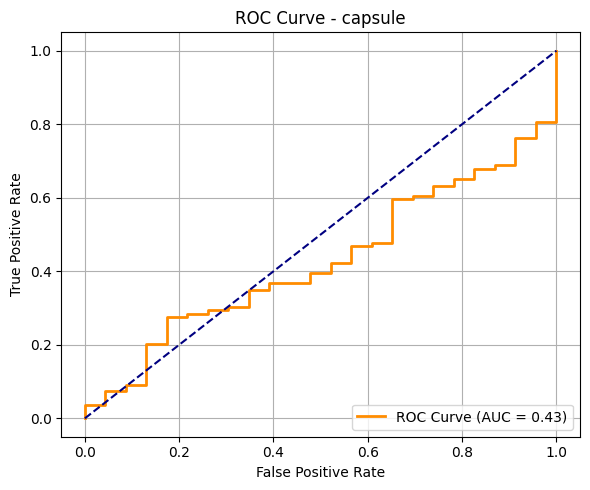

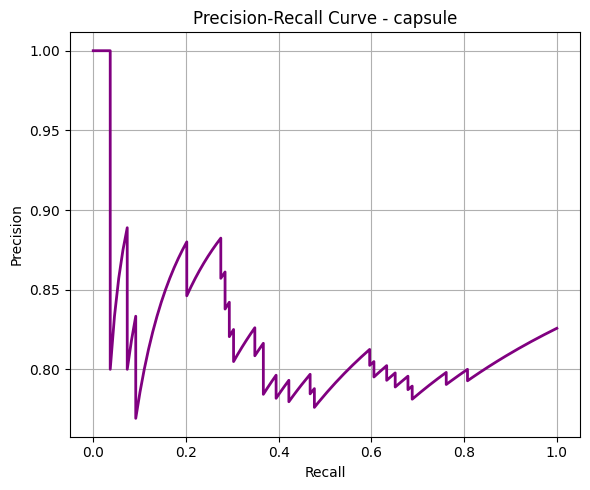

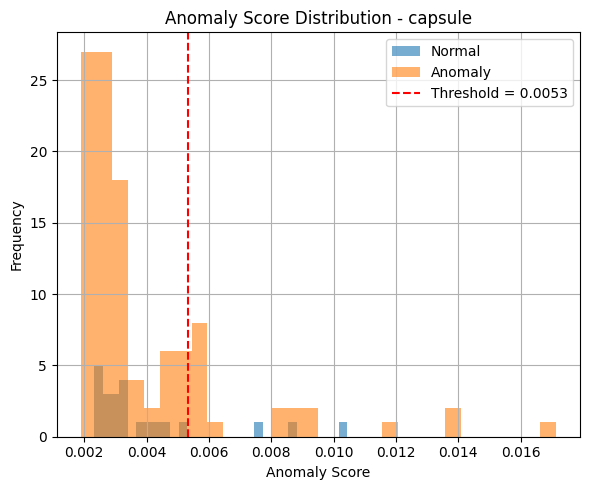


[INFO] Generating ROC and PR curves for class: carpet


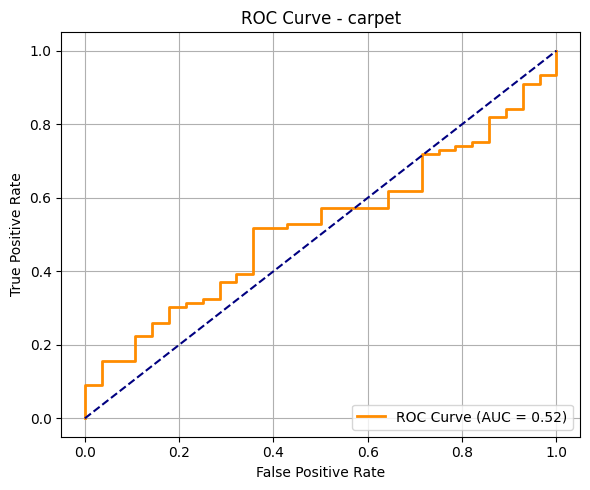

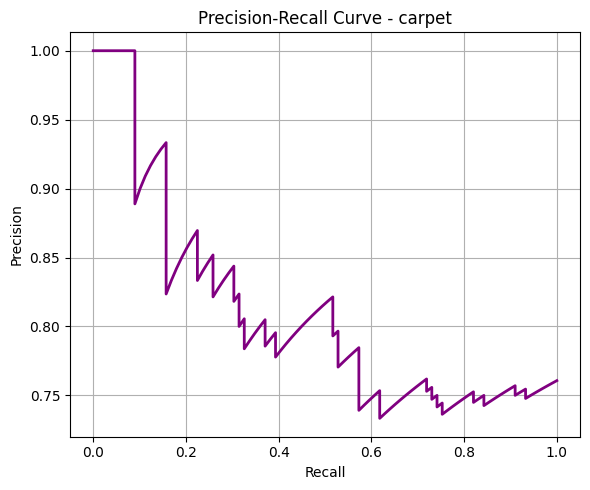

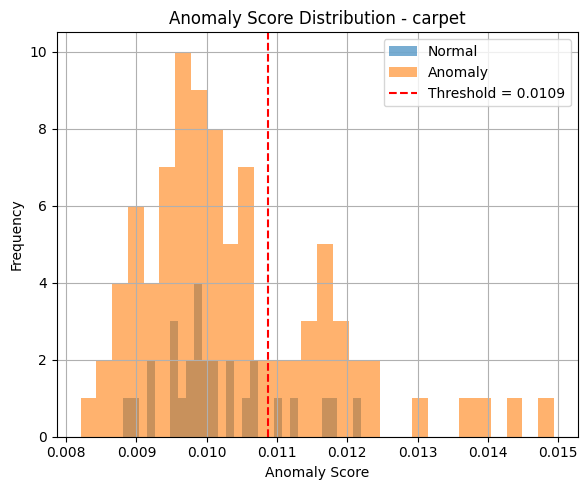


[INFO] Generating ROC and PR curves for class: grid


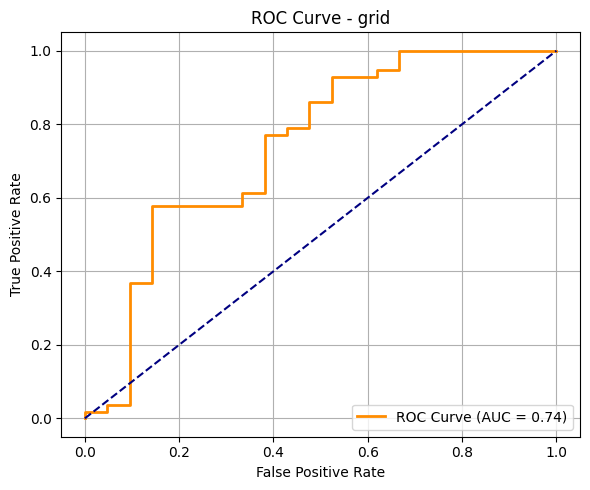

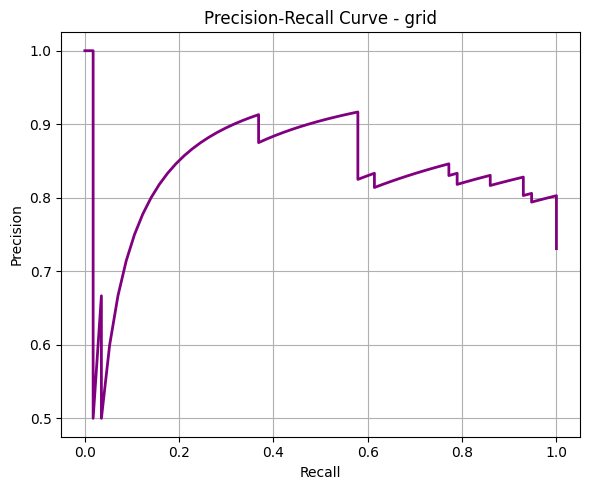

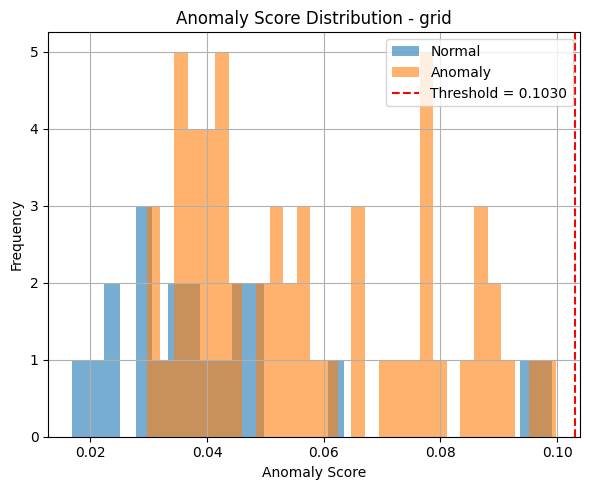


[INFO] Generating ROC and PR curves for class: hazelnut


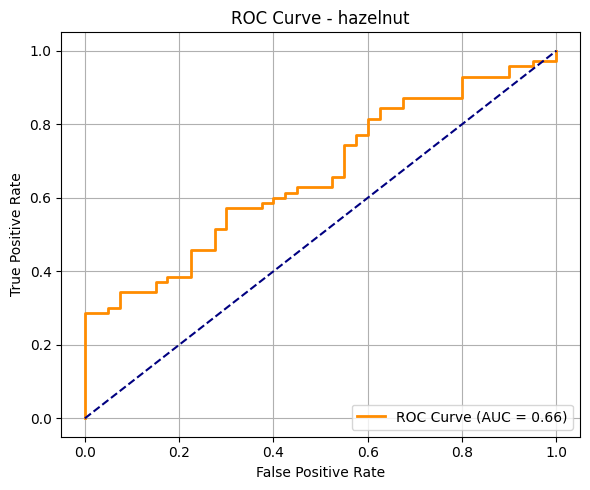

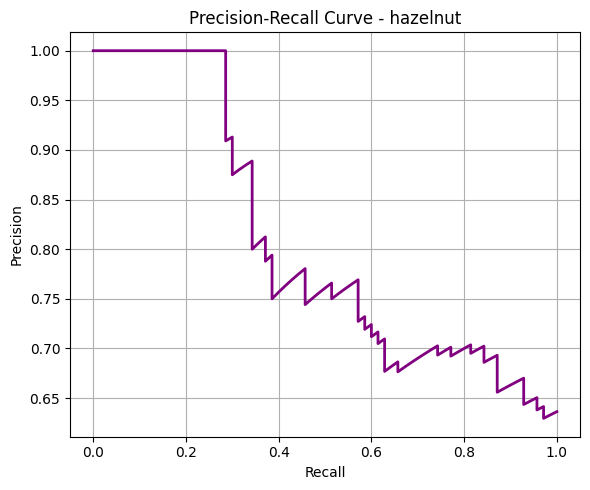

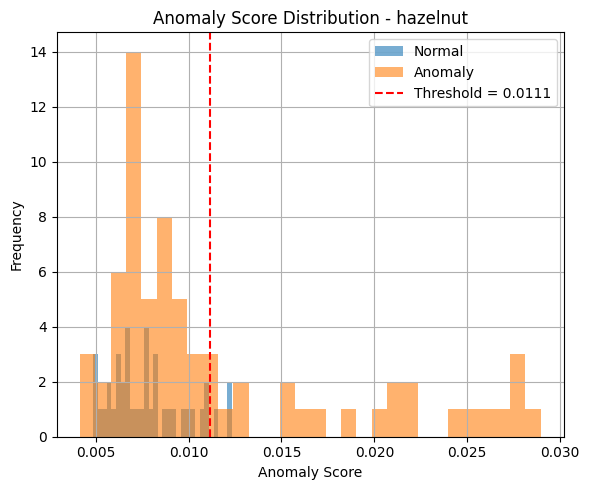


[INFO] Generating ROC and PR curves for class: leather


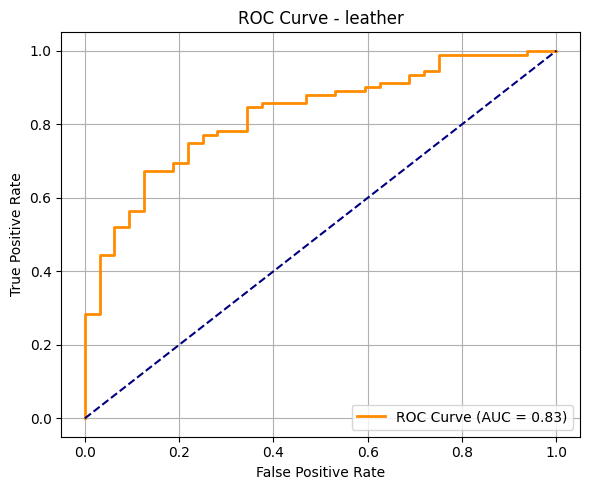

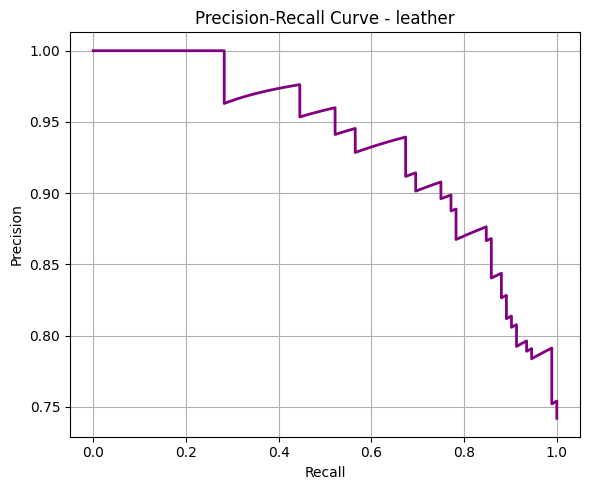

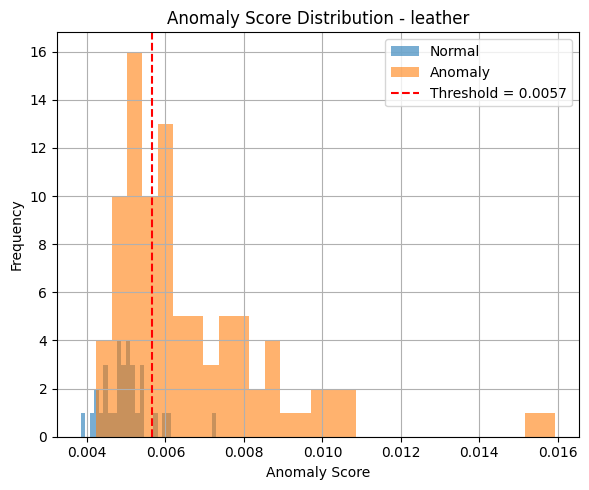


[INFO] Generating ROC and PR curves for class: metal_nut


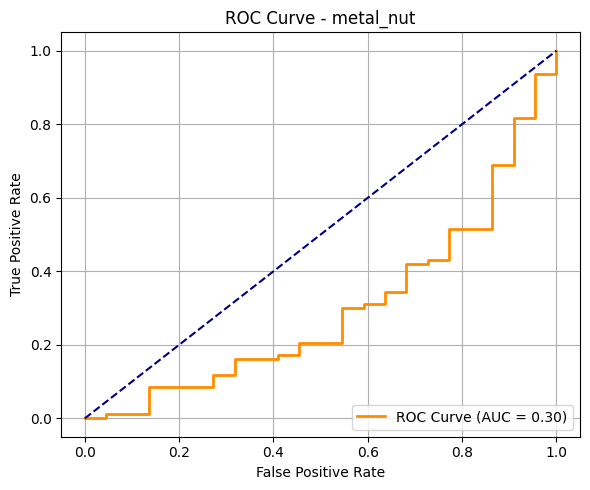

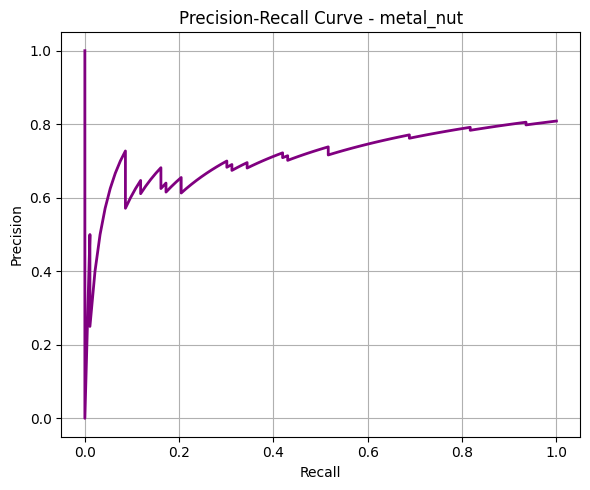

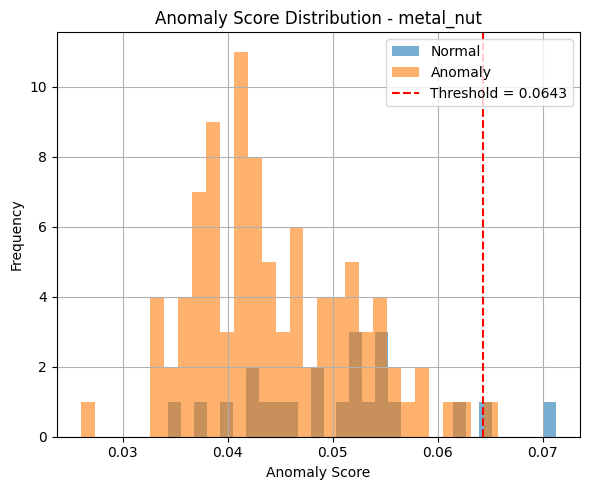


[INFO] Generating ROC and PR curves for class: pill


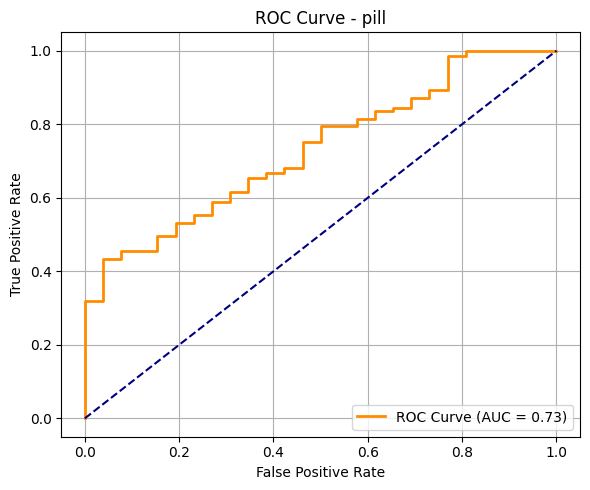

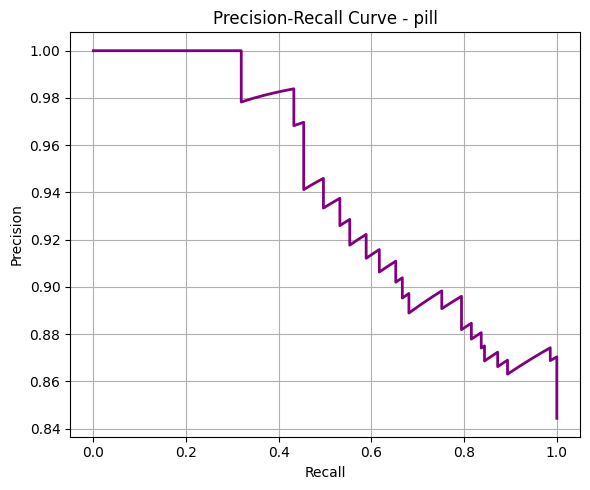

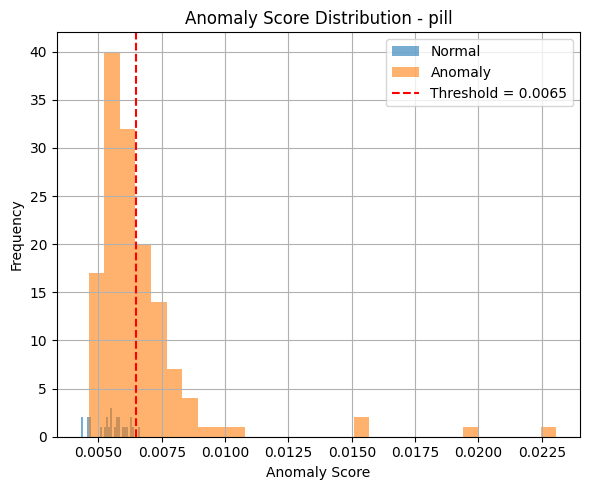


[INFO] Generating ROC and PR curves for class: screw


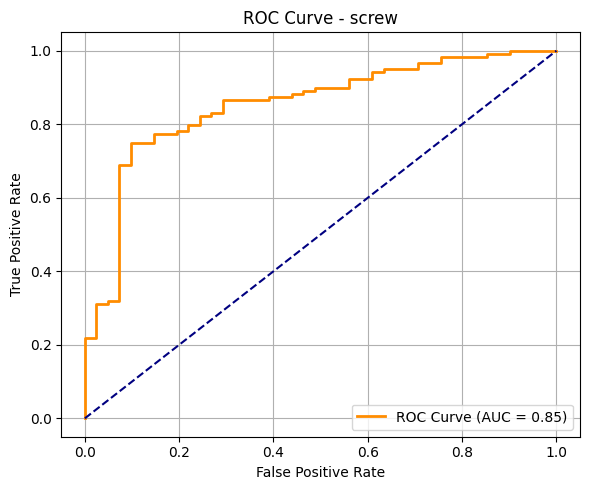

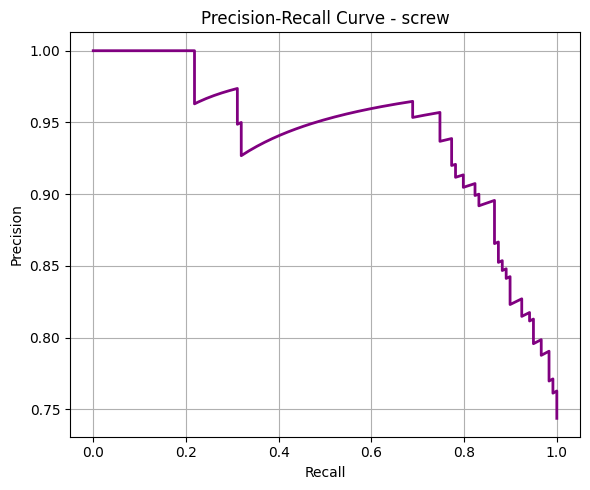

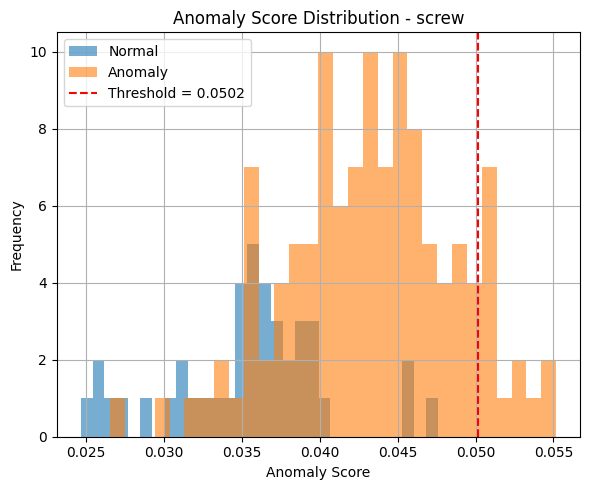


[INFO] Generating ROC and PR curves for class: tile


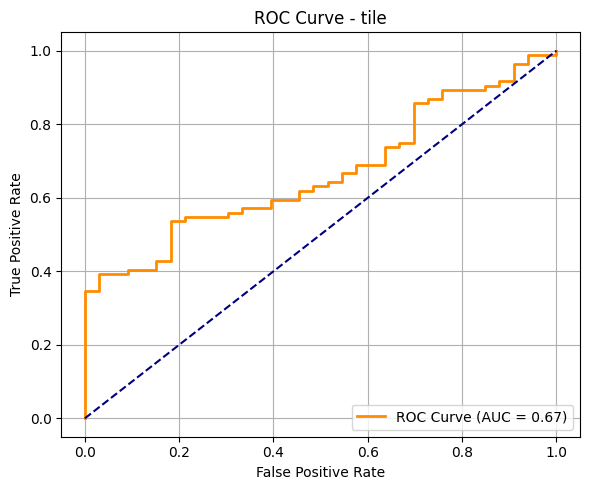

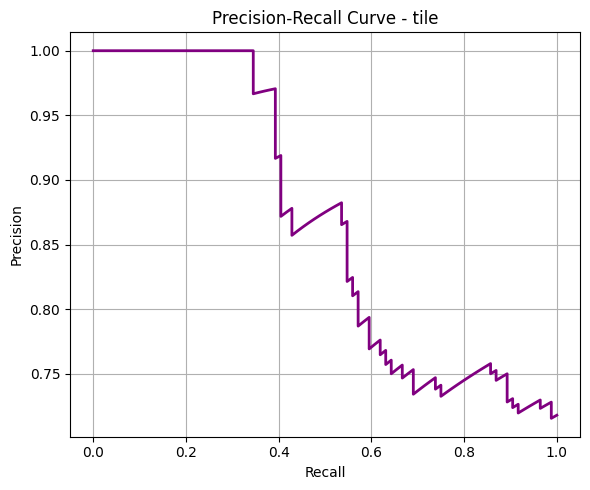

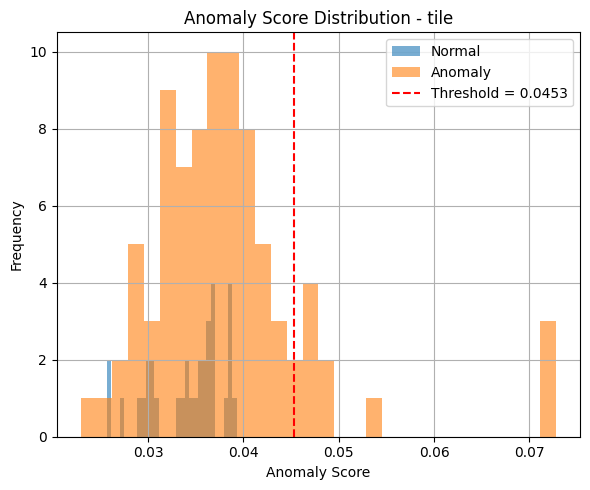


[INFO] Generating ROC and PR curves for class: toothbrush


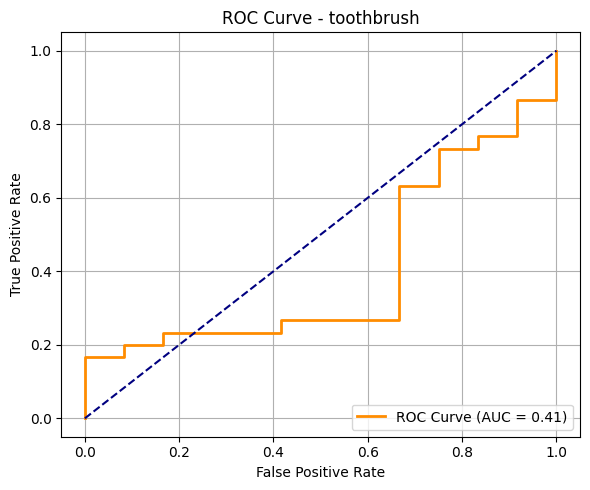

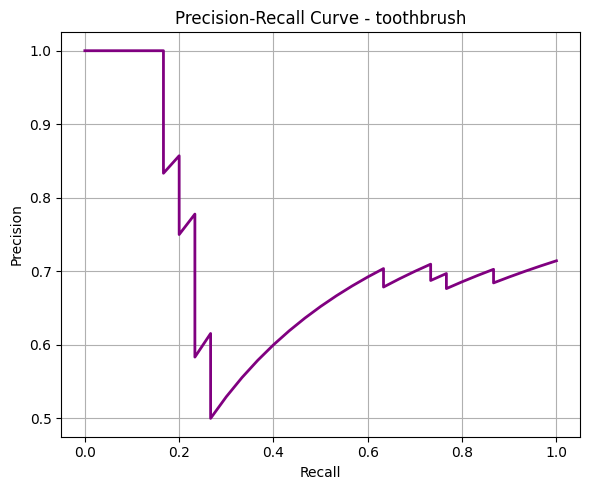

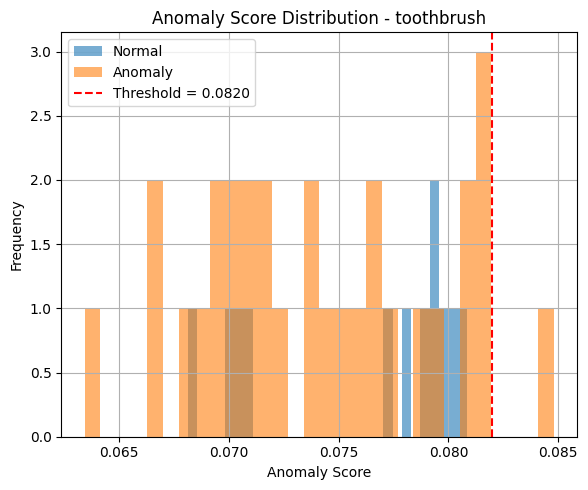


[INFO] Generating ROC and PR curves for class: transistor


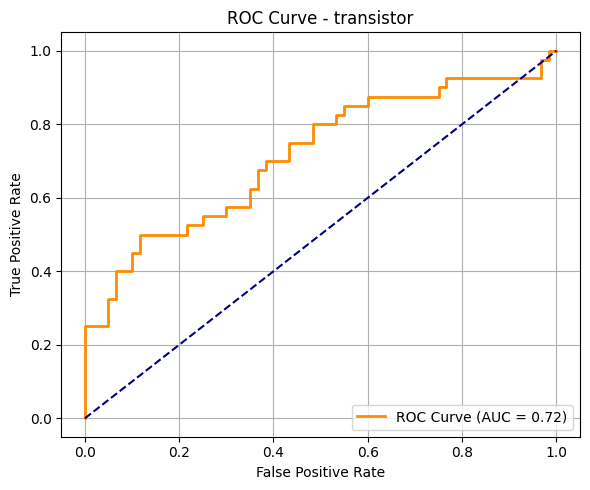

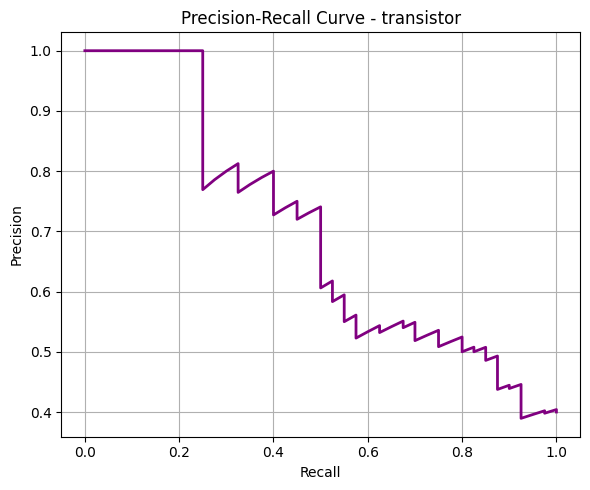

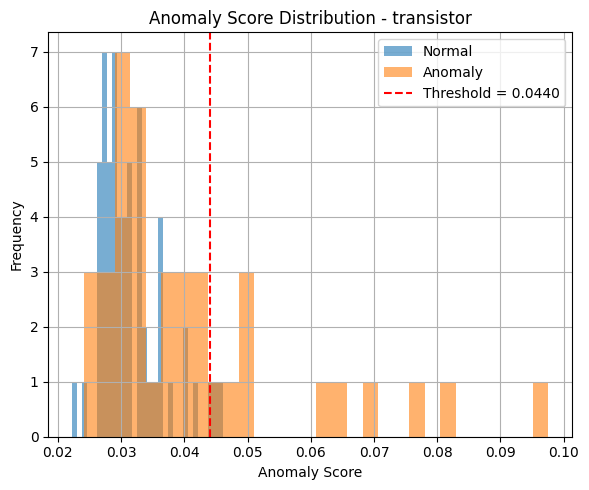


[INFO] Generating ROC and PR curves for class: wood


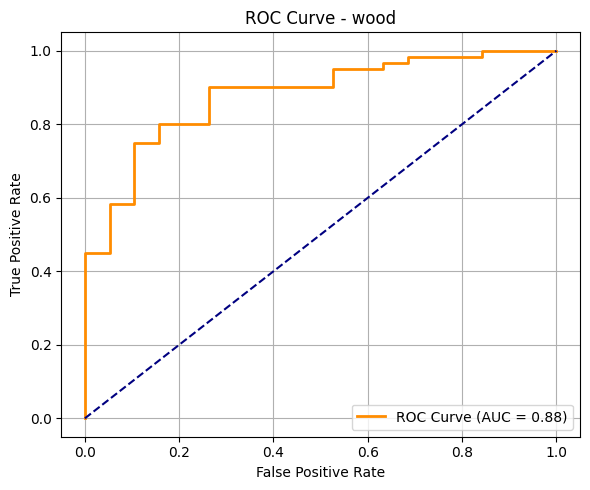

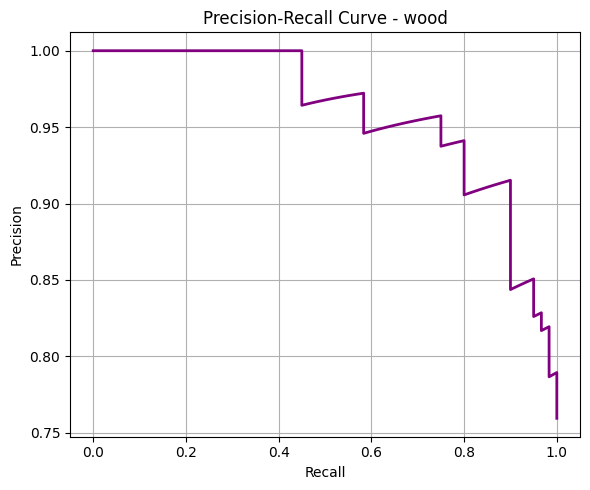

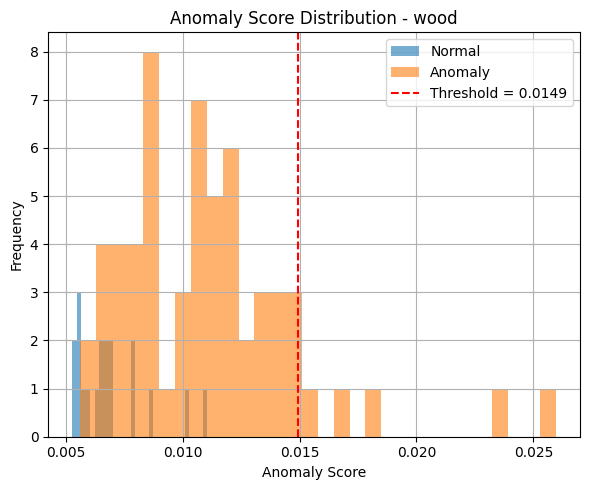


[INFO] Generating ROC and PR curves for class: zipper


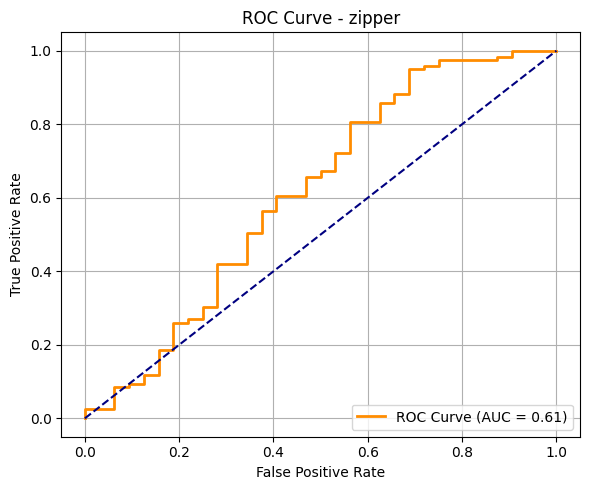

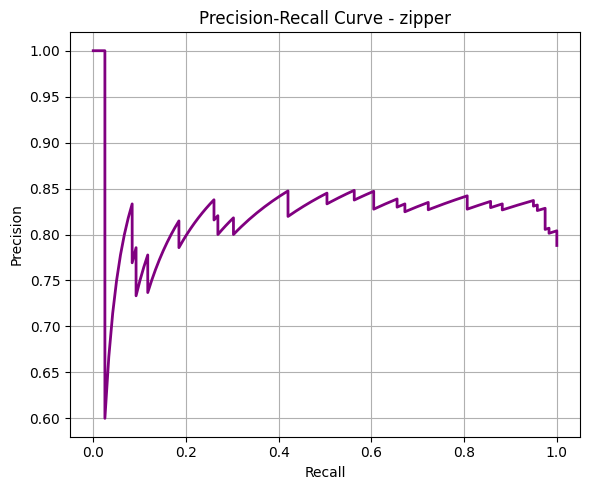

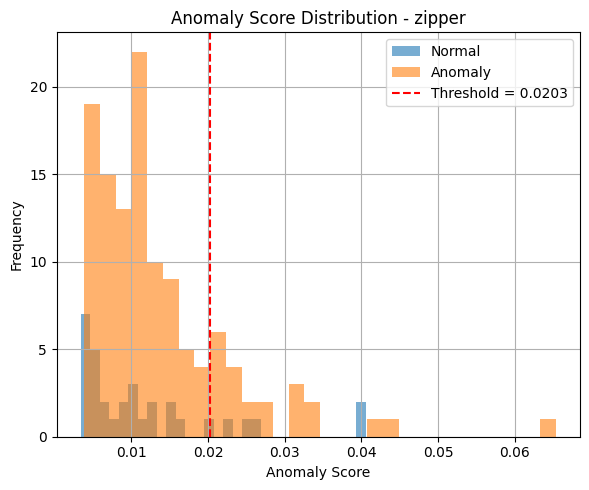

In [12]:
# ------------------------
# ROC Curve, PR Curve, and Score Distribution - BONUS
# ------------------------
from sklearn.metrics import roc_curve, auc, precision_recall_curve

for class_name in classes:
    print(f"\n[INFO] Generating ROC and PR curves for class: {class_name}")

    # Filter scores and labels for this class
    scores = [s for s, n in zip(anomaly_scores, class_names_eval) if n == class_name]
    true = [t for t, n in zip(true_labels, class_names_eval) if n == class_name]

    # If only normal or only anomalies exist, ROC/PR is not computable
    if len(set(true)) < 2:
        print(f"[WARNING] Not enough anomaly samples for '{class_name}' to compute ROC/PR. Skipping.")
        continue

    # ------------------------
    # ROC Curve
    # ------------------------
    fpr, tpr, _ = roc_curve(true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {class_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------------
    # Precision-Recall Curve
    # ------------------------
    precision, recall, _ = precision_recall_curve(true, scores)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, color='purple')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {class_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------------
    # Anomaly Score Distribution
    # ------------------------
    plt.figure(figsize=(6, 5))
    plt.hist([s for l, s in zip(true, scores) if l == 0], bins=30, alpha=0.6, label="Normal")
    plt.hist([s for l, s in zip(true, scores) if l == 1], bins=30, alpha=0.6, label="Anomaly")
    threshold = thresholds[class_to_idx[class_name]]
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title(f"Anomaly Score Distribution - {class_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

def predict_image(image_path, encoder, generator, thresholds, class_to_idx, transform, classes):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Shape: (1, 1, 64, 64)

    # Detect class name from path
    class_name = [cls for cls in classes if cls in image_path]
    if not class_name:
        raise ValueError(f"[ERROR] Could not detect class from image path: {image_path}")
    class_id = torch.tensor([class_to_idx[class_name[0]]])

    encoder.eval()
    generator.eval()

    with torch.no_grad():
        z = encoder(image_tensor)
        recon = generator(z, class_id)
        score = torch.mean((image_tensor - recon) ** 2).item()

    threshold = thresholds.get(class_id.item(), None)
    if threshold is None:
        print(f"[WARNING] Threshold not available for class '{class_name[0]}'. Skipping.")
        return None, None

    prediction = 1 if score > threshold else 0

    # ------------------------
    # Visualization
    # ------------------------
    original = image_tensor.squeeze().cpu().numpy()  # (64, 64)
    reconstructed = recon.squeeze().cpu().numpy()   # (64, 64)
    anomaly_map = np.abs(original - reconstructed)  # Pixel-wise absolute difference

    # Denormalize for visualization (since you normalized with mean=0.5 and std=0.5)
    original = (original * 0.5) + 0.5
    reconstructed = (reconstructed * 0.5) + 0.5

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Anomaly Map")
    plt.imshow(anomaly_map, cmap="hot")
    plt.axis("off")

    plt.suptitle(f"Prediction: {'Anomaly 🚨' if prediction == 1 else 'Normal ✅'} | Score: {score:.6f} | Threshold: {threshold:.6f}")
    plt.tight_layout()
    plt.show()

    # ------------------------
    # Print Prediction Info
    # ------------------------
    print("\n===============================")
    print(f"Image Path    : {image_path}")
    print(f"Class         : {class_name[0]}")
    print(f"Anomaly Score : {score:.6f}")
    print(f"Threshold     : {threshold:.6f}")
    print(f"Prediction    : {'Anomaly 🚨' if prediction == 1 else 'Normal ✅'}")
    print("===============================\n")

    return score, prediction


/tmp/ipykernel_31/480192040.py:60: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()


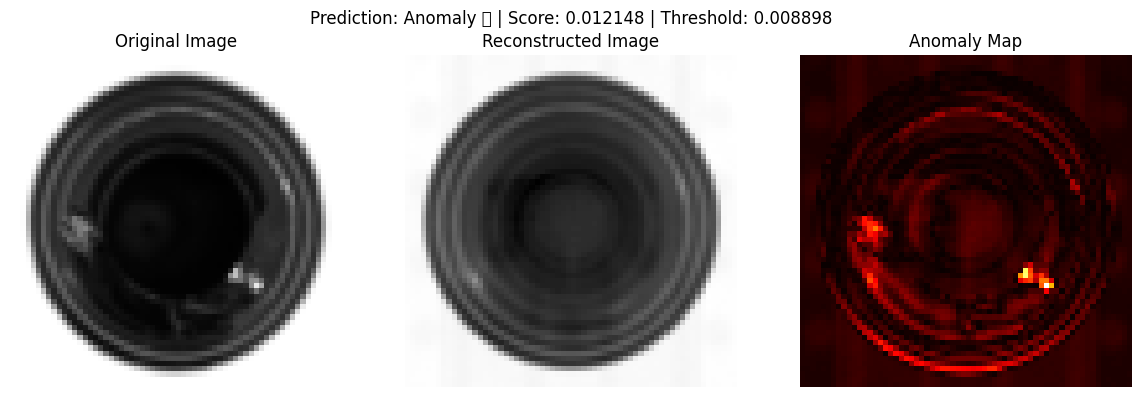


Image Path    : /kaggle/input/mvtec-ad/bottle/test/broken_large/001.png
Class         : bottle
Anomaly Score : 0.012148
Threshold     : 0.008898
Prediction    : Anomaly 🚨



(0.012148376554250717, 1)

In [15]:
image_path = "/kaggle/input/mvtec-ad/bottle/test/broken_large/001.png"
predict_image(image_path, encoder, generator, thresholds, class_to_idx, transform, classes)


In [16]:
import json
import numpy as np

# Save thresholds
np.save("thresholds.npy", thresholds)

# Save class_to_idx
with open("class_to_idx.json", "w") as f:
    json.dump(class_to_idx, f)
